In [1]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cnnLeak.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout


from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
# Set paths for the folders
train_folder = '/content/TRAIN'
valid_folder = '/content/VALID'

In [6]:
# Load CSV files
import os
train_csv = pd.read_csv(os.path.join(train_folder, '_classes.csv'))
valid_csv = pd.read_csv(os.path.join(valid_folder, '_classes.csv'))


In [7]:
# Print the first few rows to check if the data is loaded correctly
print(train_csv.head())
print(valid_csv.head())

                                            filename   sg
0  Fault_7_jpg.rf.2a5d852ba8f483e662de64e26b66f42...    0
1      5_jpg.rf.2a52145a362017738c1a86c1c13e460b.jpg    1
2  Image_101_jpg.rf.2a62ec6fa534340eaf9be81249ee4...    0
3      6_jpg.rf.2a921904eca1742bb7e231f4bb09ddf6.jpg    0
4  Fault_23_jpg.rf.2a73fa665f85f64c1addc89f8f0ba5...    0
                                            filename   sg
0  Image_21_jpg.rf.744f9cfdb999235f2941c1271c3912...    1
1  Image_130_jpg.rf.7474dba818e8c0897668e18f5812b...    0
2  Image_155_jpg.rf.748189ebe7ca4dcc907753ee13bc4...    1
3  Image_54_jpg.rf.74999afc1076197f68d92fb194dbf6...    0
4  Image_122_jpg.rf.7410f87c0def449997729587ffa14...    0


In [11]:
# Function to load and preprocess images
def load_images(csv_file, folder_path, img_size=(128, 128)):
    images = []
    labels = []

    for i in range(len(csv_file)):
        img_path = os.path.join(folder_path, csv_file.iloc[i]['filename'])
        # Load image and resize it
        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
        images.append(img)
        labels.append(csv_file.iloc[i][' sg'])

    return np.array(images), np.array(labels)

# Load images and labels
train_images, train_labels = load_images(train_csv, train_folder)
valid_images, valid_labels = load_images(valid_csv, valid_folder)

In [12]:
# Print the shapes of the data to check
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Valid images shape: {valid_images.shape}")
print(f"Valid labels shape: {valid_labels.shape}")

Train images shape: (6600, 128, 128, 3)
Train labels shape: (6600,)
Valid images shape: (1855, 128, 128, 3)
Valid labels shape: (1855,)


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Data Augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale image pixel values to [0, 1]
    rotation_range=20,            # Random rotation
    width_shift_range=0.2,        # Random horizontal shift
    height_shift_range=0.2,       # Random vertical shift
    shear_range=0.2,              # Shear transformation
    zoom_range=0.2,               # Zoom in/out
    horizontal_flip=True,         # Random horizontal flip
    fill_mode='nearest'           # Fill missing pixels after transformation
)

# For validation data, only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# Apply the transformations to the images
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
valid_generator = valid_datagen.flow(valid_images, valid_labels, batch_size=32)

# Check one batch of images and labels from the generator
# Check one batch of images and labels from the generator using the 'next()' function
x_batch, y_batch = next(train_generator)
print(f"Batch of images shape: {x_batch.shape}")
print(f"Batch of labels shape: {y_batch.shape}")


Batch of images shape: (32, 128, 128, 3)
Batch of labels shape: (32,)


In [15]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

model = models.Sequential()

# First convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # ReLU after Conv2D
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))  # ReLU after Conv2D
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(layers.Conv2D(256, (3, 3), activation='relu'))  # ReLU after Conv2D
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(512, activation='relu'))  # ReLU activation here as well
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting

# Output layer (binary classification)
model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Check the model's summary to verify the architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,063,745 (99.43 MB)

 Trainable params: 26,062,849 (99.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [16]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=len(train_images) // 32,  # Number of batches per epoch
    epochs=20,
    validation_data=valid_generator,  # Validation data generator
    validation_steps=len(valid_images) // 32,  # Number of batches per validation epoch
    verbose=1  # Show progress during training
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 46s 170ms/step - accuracy: 0.6979 - loss: 0.8609 - val_accuracy: 0.2516 - val_loss: 1.0873
Epoch 2/20
  1/206 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7812 - loss: 0.5963

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.5963 - val_accuracy: 0.3871 - val_loss: 0.9418
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.7413 - loss: 0.5294 - val_accuracy: 0.2538 - val_loss: 1.8830
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.7500 - loss: 0.5638 - val_accuracy: 0.2581 - val_loss: 1.8620
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.7574 - loss: 0.4948 - val_accuracy: 0.4370 - val_loss: 1.0808
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - accuracy: 0.8438 - loss: 0.4166 - val_accuracy: 0.2581 - val_loss: 1.1974
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 143ms/step - accuracy: 0.7649 - loss: 0.4892 - val_accuracy: 0.7511 - val_loss: 0.4624
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.6928 - val_accuracy: 0.7742 - val_loss: 0.3753
Epoch 9/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.7703 - loss: 0.4693 - val_accurac

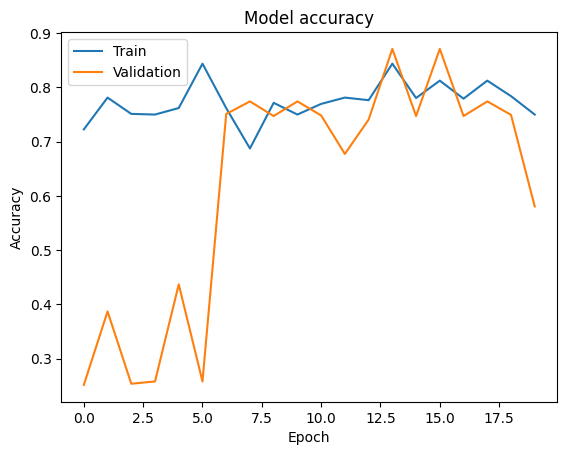

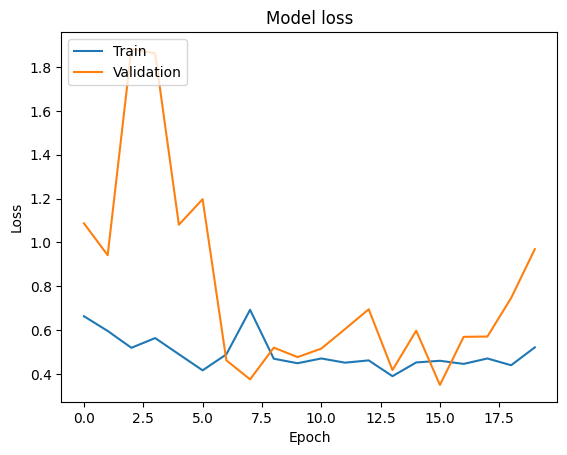

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [21]:
# Evaluate the model on the validation set
_, test_accuracy = model.evaluate(valid_generator, steps=len(valid_images) // 32)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7512 - loss: 0.7026
Test Accuracy: 0.7472587823867798


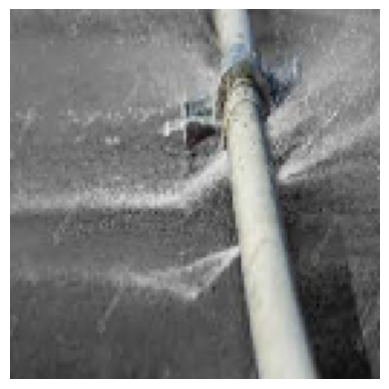

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability: [[1.]]
Leak


In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load the image with the target size (128, 128)
    img = image.load_img(img_path, target_size=(128, 128))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array / 255.0

    # Add an extra dimension for batch size (1 in this case)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

# Example: Load and preprocess an image
img_path = '/content/Leak_image.jpg'  # Update this path with your image path
processed_image, original_image = load_and_preprocess_image(img_path)

# Display the image using matplotlib
plt.imshow(original_image)
plt.axis('off')  # Hide axis labels
plt.show()

# Predict using the trained model
prediction = model.predict(processed_image)

# Print the predicted probability
print(f"Predicted probability: {prediction}")

# Interpret the prediction
if prediction < 0.5:
    print("No Leak")
else:
    print("Leak")


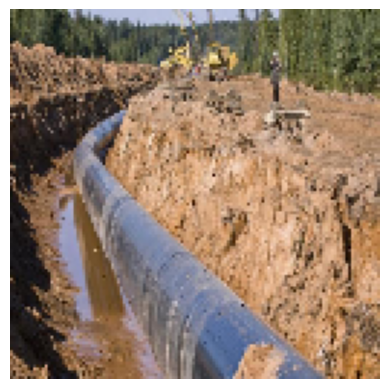

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted probability: [[0.]]
No Leak


In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load the image with the target size (128, 128)
    img = image.load_img(img_path, target_size=(128, 128))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array / 255.0

    # Add an extra dimension for batch size (1 in this case)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

# Example: Load and preprocess an image
img_path = '/content/Leak_image2.jpg'  # Update this path with your image path
processed_image, original_image = load_and_preprocess_image(img_path)

# Display the image using matplotlib
plt.imshow(original_image)
plt.axis('off')  # Hide axis labels
plt.show()

# Predict using the trained model
prediction = model.predict(processed_image)

# Print the predicted probability
print(f"Predicted probability: {prediction}")

# Interpret the prediction
if prediction < 0.5:
    print("No Leak")
else:
    print("Leak")


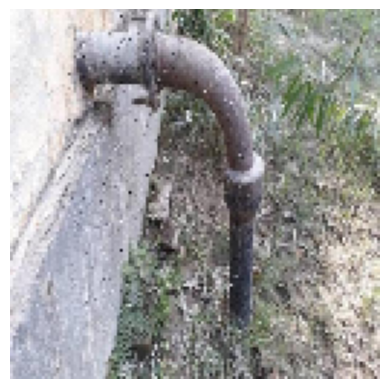

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted probability: [[0.]]
No Leak


In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load the image with the target size (128, 128)
    img = image.load_img(img_path, target_size=(128, 128))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array / 255.0

    # Add an extra dimension for batch size (1 in this case)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

# Example: Load and preprocess an image
img_path = '/content/Leak_image3.jpg'  # Update this path with your image path
processed_image, original_image = load_and_preprocess_image(img_path)

# Display the image using matplotlib
plt.imshow(original_image)
plt.axis('off')  # Hide axis labels
plt.show()

# Predict using the trained model
prediction = model.predict(processed_image)

# Print the predicted probability
print(f"Predicted probability: {prediction}")

# Interpret the prediction
if prediction < 0.5:
    print("No Leak")
else:
    print("Leak")


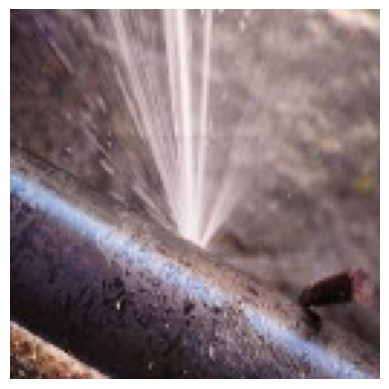

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted probability: [[1.]]
Leak


In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    # Load the image with the target size (128, 128)
    img = image.load_img(img_path, target_size=(128, 128))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array / 255.0

    # Add an extra dimension for batch size (1 in this case)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img

# Example: Load and preprocess an image
img_path = '/content/Leak_image7.jpg'  # Update this path with your image path
processed_image, original_image = load_and_preprocess_image(img_path)

# Display the image using matplotlib
plt.imshow(original_image)
plt.axis('off')  # Hide axis labels
plt.show()

# Predict using the trained model
prediction = model.predict(processed_image)

# Print the predicted probability
print(f"Predicted probability: {prediction}")

# Interpret the prediction
if prediction < 0.5:
    print("No Leak")
else:
    print("Leak")


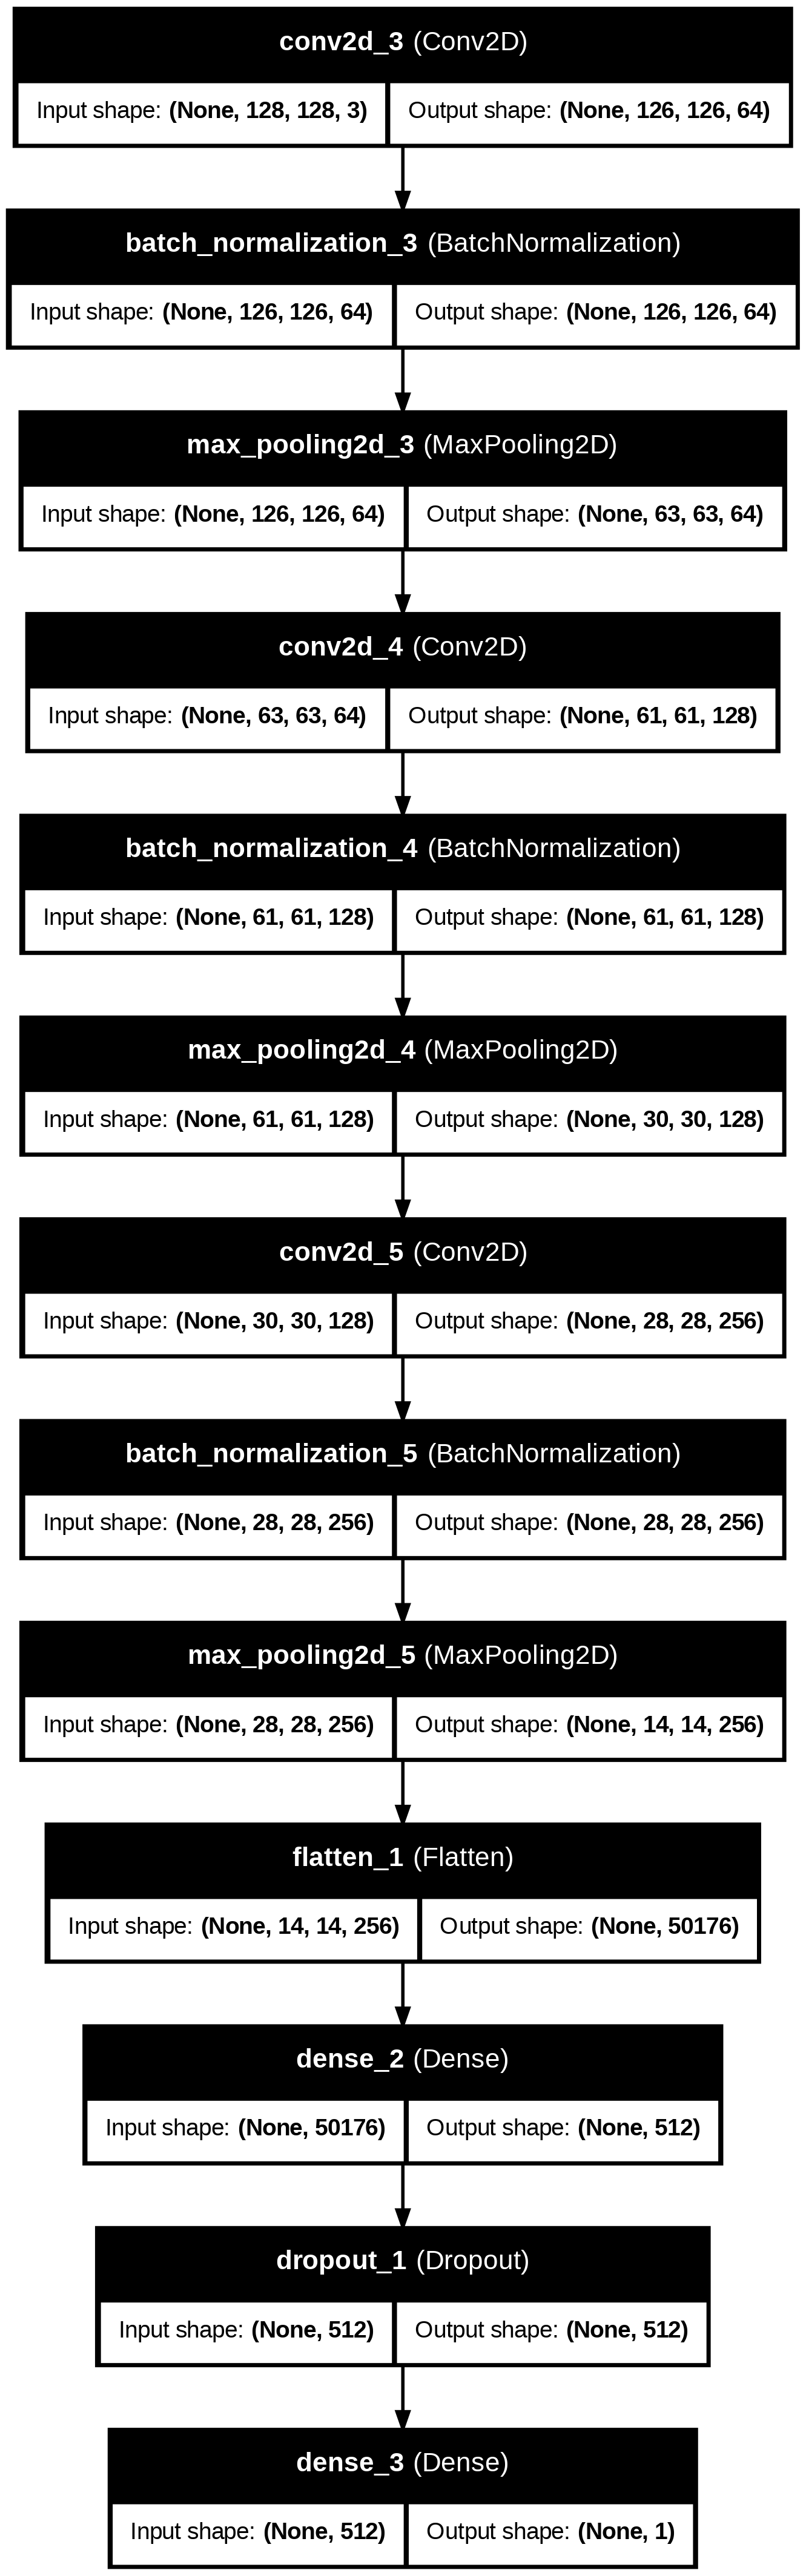

In [32]:
# Import the necessary library
from tensorflow.keras.utils import plot_model

# Generate the plot of the model's architecture
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
